In [2]:
# Libraries
import torch
import math
from tqdm import trange
from slips.samplers.mcmc import MCMCScoreEstimator
from slips.samplers.sto_loc import sto_loc_algorithm, sample_y_init
from slips.samplers.alphas import *
import matplotlib.pyplot as plt
import ot
import utils.densities as distributions

import numpy as np

In [3]:
def get_w2(samples1,samples2):
    n , m = samples1.shape[0], samples2.shape[0]
    M = ot.dist(samples1,samples2)
    a, b = torch.ones((n,),device=samples1.device) / n, torch.ones((m,),device=samples2.device) / m
    return ot.emd2(a,b,M)**.5


In [4]:
# Make a Pytorch device
device = torch.device('cuda')

In [5]:
# Make the target distribution
weights = torch.tensor([.1,.2,.3,.4],device=device)
means = torch.tensor([[0,0.],[0,11],[9,9],[11,0]],device=device)
variances = torch.tensor([[[1, .5],[.5,1]],[[.3, -0.2],[-0.2,.3]],[[1, .3],[.3,1]],[[1.2, -1],[-1,1.2]]],device=device)
target = distributions.MixtureDistribution(weights, [distributions.MultivariateGaussian(means[i],variances[i]) for i in range(4)])

In [6]:
samples_target = target.sample(1000).to(device=device)
print((samples_target.std(dim=0)))
print((samples_target**2).sum(-1).mean())

tensor([4.8635, 5.0864], device='cuda:0')
tensor(123.6498, device='cuda:0')


In [7]:
# Get the score of the target distribution
def target_log_prob_and_grad(y):
    y_ = torch.autograd.Variable(y, requires_grad=True)
    log_prob_y = target.log_prob(y_).flatten()
    return log_prob_y, torch.autograd.grad(log_prob_y.sum(), y_)[0].detach()

In [8]:
def get_samples_slips(t0, std):
    sigma = torch.tensor(std)
    alpha = AlphaGeometric(a=1.0, b=1.0)

    # Hyper-parameters
    n_samples = 2048
    K = 1024
    n_mcmc_steps = 32
    n_mcmc_chains = 4
    epsilon, epsilon_end, T = t0, 6.62e-03, 1.0

    # Prepare the score estimator
    score_est = MCMCScoreEstimator(
        step_size=1e-5,
        n_mcmc_samples=n_mcmc_steps,
        log_prob_and_grad=target_log_prob_and_grad,
        n_mcmc_chains=n_mcmc_chains,
        keep_mcmc_length=int(0.5 * n_mcmc_steps)
    )

    # Sample the initial point with Langevin-within-Langevin
    y_init = sample_y_init((n_samples, 2), sigma=sigma, epsilon=epsilon, alpha=alpha, device=device,
            n_langevin_steps=32, langevin_init=True, score_est=score_est, score_type='mc')

    # Run the SLIPS algorithm
    samples = sto_loc_algorithm(alpha=alpha, y_init=y_init, K=K, T=T, sigma=sigma, score_est=score_est, score_type='mc',
        epsilon=epsilon, epsilon_end=epsilon_end, use_exponential_integrator=True, use_snr_discretization=True,
        verbose=True
    ).detach().cpu()

    return samples

In [9]:
samples = get_samples_slips(.35,5).to(device)
print(f'{.35 : .5f} --- {get_w2(samples,samples_target) : .5f}')


100%|██████████| 1023/1023 [03:32<00:00,  4.81it/s]


 0.35000 ---  8.41274


In [10]:
t0s = np.float_power(10,np.arange(-7, 0,1))
t0s = np.concatenate((t0s, np.array([.2,.3,.35,.4,.5])))
print(t0s)
std_target = 5
for t0 in t0s:
    samples = get_samples_slips(t0,std_target).to(device)
    print(f'{t0 : .5f} --- {get_w2(samples,samples_target) : .5f}')

[1.0e-07 1.0e-06 1.0e-05 1.0e-04 1.0e-03 1.0e-02 1.0e-01 2.0e-01 3.0e-01
 3.5e-01 4.0e-01 5.0e-01]


100%|██████████| 1023/1023 [03:37<00:00,  4.70it/s]


 0.00000 ---  17962.07031


100%|██████████| 1023/1023 [03:20<00:00,  5.10it/s]


 0.00000 ---  5496.64355


100%|██████████| 1023/1023 [00:49<00:00, 20.60it/s]


 0.00001 ---  653.80280


100%|██████████| 1023/1023 [00:48<00:00, 21.21it/s]


 0.00010 ---  5.21865


100%|██████████| 1023/1023 [00:49<00:00, 20.81it/s]


 0.00100 ---  5.10800


100%|██████████| 1023/1023 [00:49<00:00, 20.80it/s]


 0.01000 ---  5.54249


100%|██████████| 1023/1023 [00:51<00:00, 19.93it/s]


 0.10000 ---  6.77297


100%|██████████| 1023/1023 [00:50<00:00, 20.32it/s]


 0.20000 ---  7.53148


100%|██████████| 1023/1023 [00:51<00:00, 20.02it/s]


 0.30000 ---  8.11765


100%|██████████| 1023/1023 [00:53<00:00, 19.17it/s]


 0.35000 ---  8.53969


100%|██████████| 1023/1023 [00:47<00:00, 21.47it/s]


 0.40000 ---  8.67329


100%|██████████| 1023/1023 [00:44<00:00, 22.85it/s]


 0.50000 ---  9.26004


In [11]:
t0s = np.float_power(10,np.arange(-7, 0,1))
std_target = 5
for t0 in t0s:
    samples = get_samples_slips(t0,std_target).to(device)
    print(f'{t0 : .5f} --- {get_w2(samples,samples_target) : .5f}')


100%|██████████| 1023/1023 [00:45<00:00, 22.24it/s]


 0.00000 ---  17818.11523


100%|██████████| 1023/1023 [00:46<00:00, 21.90it/s]


 0.00000 ---  5286.01562


100%|██████████| 1023/1023 [00:46<00:00, 22.00it/s]


 0.00001 ---  702.44720


100%|██████████| 1023/1023 [00:47<00:00, 21.69it/s]


 0.00010 ---  5.23430


100%|██████████| 1023/1023 [00:48<00:00, 21.31it/s]


 0.00100 ---  5.28475


100%|██████████| 1023/1023 [00:47<00:00, 21.71it/s]


 0.01000 ---  5.45479


100%|██████████| 1023/1023 [00:51<00:00, 20.00it/s]


 0.10000 ---  6.40194


in practice we set 10k independent of the target, we observed isnensitivity and we always see that samples got accepted so the tthreshohld didnt get reached

In [12]:
# Display samples
plt.figure(figsize=(5,5))
plt.scatter(y_init[:,0].cpu().numpy(), y_init[:,1].cpu().numpy())
plt.scatter(samples[:,0], samples[:,1], alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Samples from SLIPS')
plt.show()

NameError: name 'y_init' is not defined

<Figure size 500x500 with 0 Axes>

tensor(5.0300)


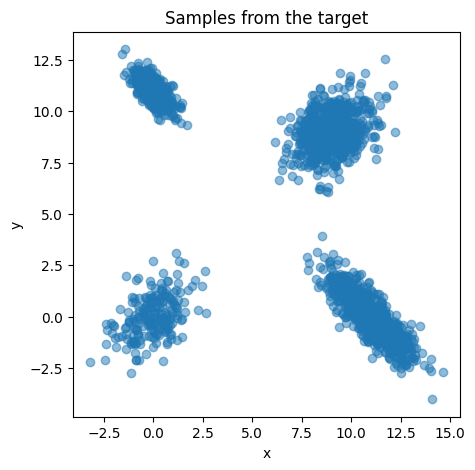

In [ ]:
# Display target samples
plt.figure(figsize=(5,5))
target_samples = target.sample(samples.shape[0]).cpu()
print(target_samples.std())
plt.scatter(target_samples[:,0], target_samples[:,1], alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Samples from the target')
plt.show()

tensor(8.3469)